In [3]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# Create an ImageDataGenerator for rescaling the pixel values between 0 and 1
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow data from directories (train, validation, and test)
train_data_gen = train_datagen.flow_from_directory(
    'cats_and_dogs/train',  # Path to training data
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize all images to 150x150
    batch_size=BATCH_SIZE,  # Number of images to process per batch
    class_mode='binary'  # Binary classification (cat or dog)
)

validation_data_gen = validation_datagen.flow_from_directory(
    'cats_and_dogs/validation',  # Path to validation data
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize all images to 150x150
    batch_size=BATCH_SIZE,  # Number of images to process per batch
    class_mode='binary'  # Binary classification (cat or dog)
)

# For test data, shuffle=False to keep the predictions ordered
test_data_gen = test_datagen.flow_from_directory(
    'cats_and_dogs/test',  # Path to test data
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize all images to 150x150
    batch_size=1,  # Only 1 image per batch for inference
    class_mode=None,  # We don't need labels for the test set
    shuffle=False  # Don't shuffle the test images
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


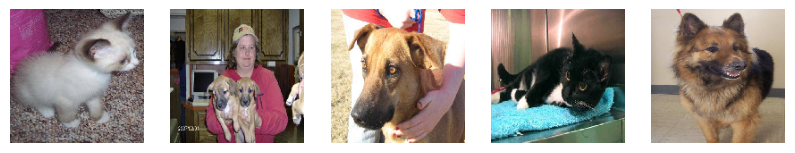

In [6]:
import matplotlib.pyplot as plt

def plotImages(images, labels=None, probs=None):
    plt.figure(figsize=(10, 10))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i])
        if labels:
            plt.title(labels[i])
        if probs:
            plt.title(f"{probs[i]:.2f}%")
        plt.axis('off')
    plt.show()

# Get a batch of images and labels
images, labels = next(train_data_gen)
plotImages(images)


In [7]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values
    rotation_range=40,  # Random rotations between 0 and 40 degrees
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Random shearing transformations
    zoom_range=0.2,  # Random zooms
    horizontal_flip=True,  # Random horizontal flips
    fill_mode='nearest'  # Fill in missing pixels after transformations
)

train_data_gen = train_image_generator.flow_from_directory(
    'cats_and_dogs/train',  # Path to training data
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize all images to 150x150
    batch_size=BATCH_SIZE,  # Number of images per batch
    class_mode='binary'  # Binary classification (cat or dog)
)


Found 2000 images belonging to 2 classes.


Found 2000 images belonging to 2 classes.


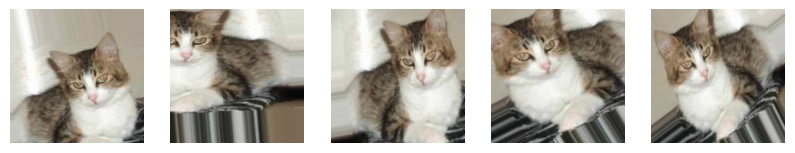

In [8]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [9]:
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Sigmoid output for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary cross-entropy for binary classification
              metrics=['accuracy'])  # We want to track accuracy during training


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // BATCH_SIZE,
    epochs=10,  # You can tweak this number based on your results
    validation_data=validation_data_gen,
    validation_steps=validation_data_gen.samples // BATCH_SIZE
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
16/62 ━━━━━━━━━━━━━━━━━━━━ 5:32 7s/step - accuracy: 0.5124 - loss: 1.3217

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legent(loc='lower right')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [ ]:
# Predict test images
test_images = next(test_data_gen)
predictions = model.predict(test_data_gen, steps=test_data_gen.samples)

# Convert probabilities to labels (0 for cat, 1 for dog)
predicted_labels = (predictions > 0.5).astype("int32")

# Plot the test images and predictions
plotImages(test_images, probs=predicted_labels)


In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")